# Model Part

## Load data into code from kaggle

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = ""

# Load the latest version
df_true = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "clmentbisaillon/fake-and-real-news-dataset",
    "True.csv"
)
df_fake = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "clmentbisaillon/fake-and-real-news-dataset",
    "Fake.csv"
)

print("True news:", df_true.head())
print("Fake news:", df_fake.head())

Using Colab cache for faster access to the 'fake-and-real-news-dataset' dataset.
Using Colab cache for faster access to the 'fake-and-real-news-dataset' dataset.
True news:                                                title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017 

## Combine two dataset into one

In [3]:
import pandas as pd

df_true['label'] = 0
df_fake['label'] = 1
df = pd.concat([df_true, df_fake]).reset_index(drop=True)
print(df['label'].value_counts())
print(df.isnull().sum())

label
1    23481
0    21417
Name: count, dtype: int64
title      0
text       0
subject    0
date       0
label      0
dtype: int64


## Preproces text

In [4]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# download nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# preprocessing function
def preprocess_text(text):
    # to lowercase
    text = text.lower()
    # remove punktuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # tokenize
    tokens = word_tokenize(text)
    # Remove stop words and non words
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    # Lematization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Combine words to sentence
    return ' '.join(tokens)

# Preprocess dataframe
df['clean_text'] = df['text'].apply(preprocess_text)

print(df[['text', 'clean_text']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                                text  \
0  WASHINGTON (Reuters) - The head of a conservat...   
1  WASHINGTON (Reuters) - Transgender people will...   
2  WASHINGTON (Reuters) - The special counsel inv...   
3  WASHINGTON (Reuters) - Trump campaign adviser ...   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...   

                                          clean_text  
0  washington reuters head conservative republica...  
1  washington reuters transgender people allowed ...  
2  washington reuters special counsel investigati...  
3  washington reuters trump campaign adviser geor...  
4  seattlewashington reuters president donald tru...  


## Visualize Word Cloud

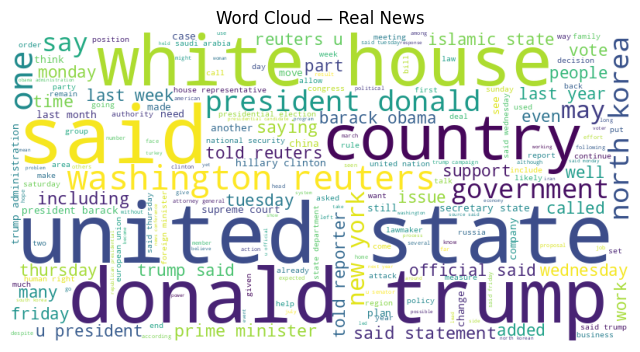

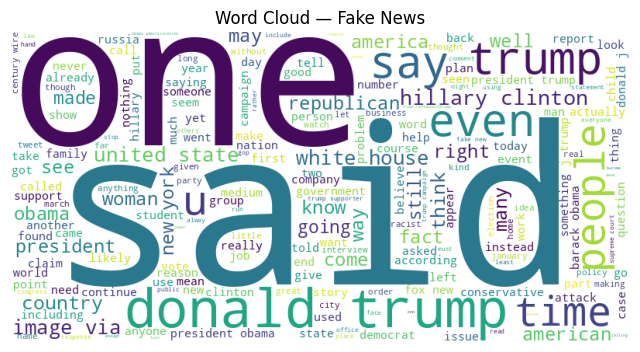

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# for Real News
real_words = ' '.join(df[df['label']==0]['clean_text'])
wc_real = WordCloud(width=800, height=400, background_color='white').generate(real_words)
plt.figure(figsize=(8,6))
plt.imshow(wc_real)
plt.axis('off')
plt.title('Word Cloud — Real News')
plt.show()

# for Fake News
fake_words = ' '.join(df[df['label']==1]['clean_text'])
wc_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_words)
plt.figure(figsize=(8,6))
plt.imshow(wc_fake)
plt.axis('off')
plt.title('Word Cloud — Fake News')
plt.show()

## Vectorization and Embending prepare

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = vectorizer.fit_transform(df['clean_text'])

model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
X_emb = model.encode(df['clean_text'].tolist(), show_progress_bar=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1404 [00:00<?, ?it/s]

## Split to train/test, build-fit models

In [7]:
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

vec_methods = {'TF-IDF': X_tfidf, 'Emb': X_emb}
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'MultinomialNB': MultinomialNB(),
    'SVM': LinearSVC(max_iter=1000)
}

results = []
confusion_matrices = {}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for vec_name, X in vec_methods.items():
    for model_name, model in models.items():
        # NB works only with TF-IDF, skip Embending
        if model_name == 'MultinomialNB' and vec_name != 'TF-IDF':
            continue
        # Train models
        accs, precs, recalls, f1s, aucs, cms, times = [], [], [], [], [], [], []
        for train_idx, test_idx in kf.split(X, df['label']):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = df['label'].iloc[train_idx], df['label'].iloc[test_idx]
            start = time.time()
            model.fit(X_train, y_train)
            end = time.time()
            times.append(end - start)

            y_pred = model.predict(X_test)
            try:
                y_proba = model.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, y_proba)
            except Exception:
                auc = np.nan
            accs.append(accuracy_score(y_test, y_pred))
            precs.append(precision_score(y_test, y_pred, average='macro'))
            recalls.append(recall_score(y_test, y_pred, average='macro'))
            f1s.append(f1_score(y_test, y_pred, average='macro'))
            aucs.append(auc)
            cms.append(confusion_matrix(y_test, y_pred))

        results.append({
            'Vectorizer+Model': f'{vec_name} + {model_name}',
            'Accuracy': np.mean(accs),
            'Precision': np.mean(precs),
            'Recall': np.mean(recalls),
            'F1-macro': np.mean(f1s),
            'ROC-AUC': np.nanmean(aucs),
            'Training Time (s)': np.sum(times)
        })
        confusion_matrices[f"{vec_name}+{model_name}"] = cms

/tmp/ipython-input-3301641731.py:55: RuntimeWarning: Mean of empty slice
  'ROC-AUC': np.nanmean(aucs),
/tmp/ipython-input-3301641731.py:55: RuntimeWarning: Mean of empty slice
  'ROC-AUC': np.nanmean(aucs),


## Results

In [8]:
results_df = pd.DataFrame(results)
print(results_df.round(3))
results_df.head()

              Vectorizer+Model  Accuracy  Precision  Recall  F1-macro  \
0  TF-IDF + LogisticRegression     0.986      0.986   0.986     0.986   
1       TF-IDF + MultinomialNB     0.930      0.930   0.929     0.929   
2                 TF-IDF + SVM     0.994      0.994   0.994     0.994   
3     Emb + LogisticRegression     0.961      0.961   0.961     0.961   
4                    Emb + SVM     0.969      0.969   0.970     0.969   

   ROC-AUC  Training Time (s)  
0    0.998              3.205  
1    0.977              0.160  
2      NaN              3.884  
3    0.993              4.467  
4      NaN             11.808  


,Vectorizer+Model,Accuracy,Precision,Recall,F1-macro,ROC-AUC,Training Time (s)
0,TF-IDF + LogisticRegression,0.985768,0.985667,0.985823,0.985740,0.998497,3.205280
1,TF-IDF + MultinomialNB,0.929685,0.929813,0.929252,0.929493,0.976870,0.160188
2,TF-IDF + SVM,0.993563,0.993532,0.993569,0.993550,NaN,3.884369
3,Emb + LogisticRegression,0.960800,0.960579,0.960957,0.960734,0.992765,4.467260
4,Emb + SVM,0.969375,0.969175,0.969521,0.969322,NaN,11.807833


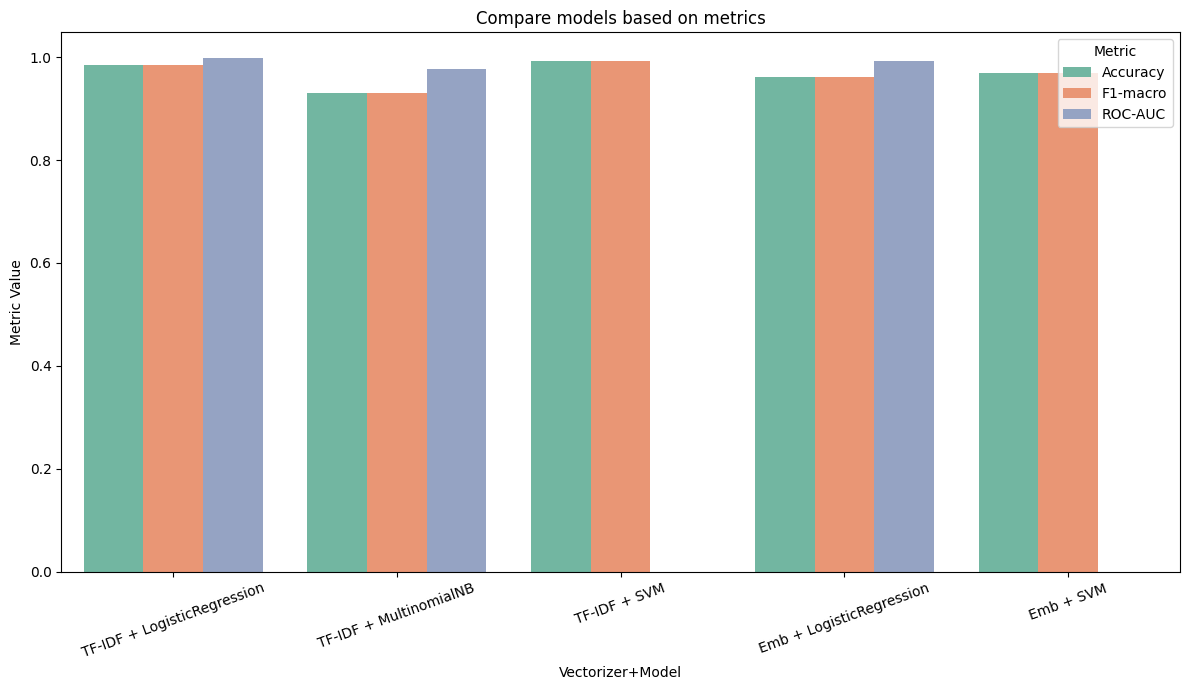

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'F1-macro', 'ROC-AUC']
results_melted = results_df.melt(id_vars='Vectorizer+Model', value_vars=metrics)

plt.figure(figsize=(12,7))
sns.barplot(
    data=results_melted,
    x='Vectorizer+Model',
    y='value',
    hue='variable',
    palette='Set2'
)
plt.xticks(rotation=20)
plt.ylabel('Metric Value')
plt.title('Compare models based on metrics')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1870635052.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


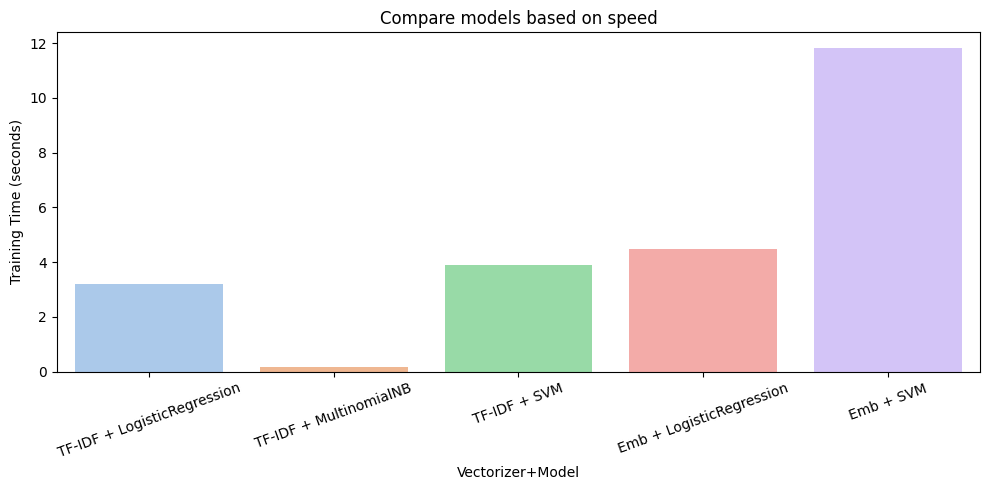

In [10]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=results_df,
    x='Vectorizer+Model',
    y='Training Time (s)',
    palette='pastel'
)
plt.xticks(rotation=20)
plt.ylabel('Training Time (seconds)')
plt.title('Compare models based on speed')
plt.tight_layout()
plt.show()

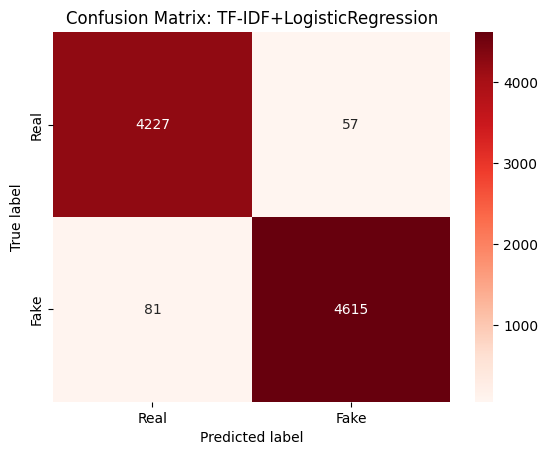

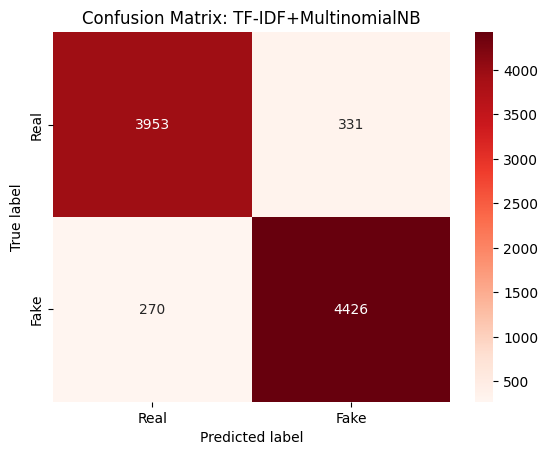

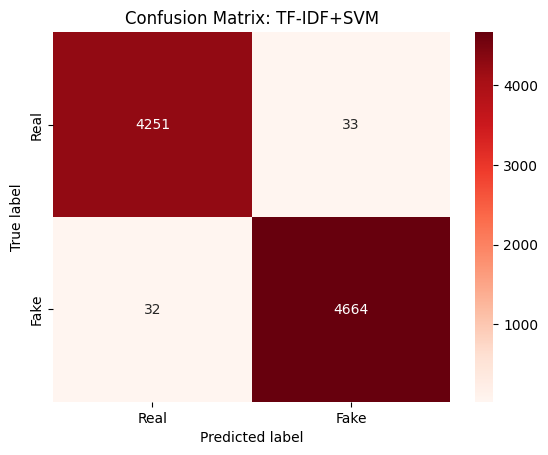

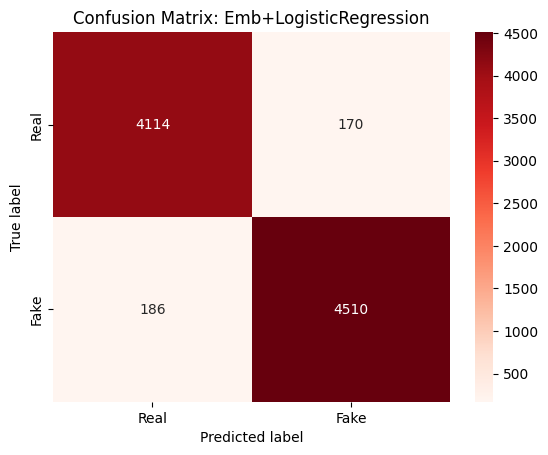

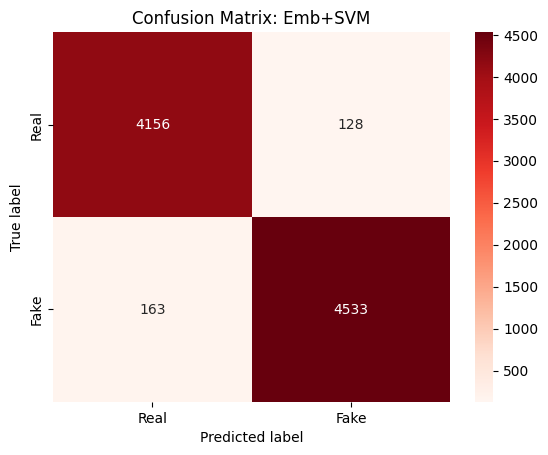

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

for vec_name, X in vec_methods.items():
    for model_name, model in models.items():
        if model_name == 'MultinomialNB' and vec_name != 'TF-IDF':
            continue
        cms = confusion_matrices[f"{vec_name}+{model_name}"][0]
        sns.heatmap(cms, annot=True, fmt='d', cmap='Reds', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(f"Confusion Matrix: {vec_name}+{model_name}")
        plt.show()

## Best model

In [12]:
from sklearn.linear_model import LogisticRegression
import joblib

def train_model(X, y, save_path='model.pkl'):
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    joblib.dump(model, save_path)
    return model

def load_model(path='model.pkl'):
    return joblib.load(path)

def predict_news(model, X_new):
    return model.predict(X_new)

In [13]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], stratify=df['label'], test_size=0.2, random_state=42)

best_model = train_model(X_train, y_train)

y_pred = best_model.predict(X_test)

y_proba = best_model.predict_proba(X_test)[:, 1]

model_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='macro'),
    'Recall': recall_score(y_test, y_pred, average='macro'),
    'F1-macro': f1_score(y_test, y_pred, average='macro'),
    'ROC-AUC': roc_auc_score(y_test, y_proba)
}

## Analyzing errors with Word Cloud

In [14]:
wrong_idx = np.where(y_pred != y_test)[0]
wrong_examples = X_test[wrong_idx]
wrong_labels = y_test.iloc[wrong_idx]
error_df = df.iloc[wrong_idx]
print(error_df.sample(10))
error_df.sample(10)

                                                  title  \
549   U.S. calls Myanmar moves against Rohingya 'eth...   
1573  U.S. House fails to pass FAA extension, hurric...   
4490  House Speaker Ryan says healthcare talks at 'c...   
3188  Factbox: U.S. lawmaker, others in hospital aft...   
2318  Senate confirms new USAID administrator Mark G...   
1074  Factbox: What's in the Republican tax cut plan...   
3919  White House says 'critical' that House passes ...   
1182  Judge blocks latest Trump curbs on people ente...   
4438  Senate set for pivotal vote on Supreme Court n...   
4659  House Intelligence postpones closed session wi...   

                                                   text       subject  \
549   WASHINGTON (Reuters) - The United States on We...  politicsNews   
1573  WASHINGTON (Reuters) - The U.S. House of Repre...  politicsNews   
4490  WASHINGTON (Reuters) - U.S. House of Represent...  politicsNews   
3188  (Reuters) - A senior member of the U.S. House ...  p

,title,text,subject,date,label,clean_text
1758,Democrats probe whether Flynn pushed nuclear p...,WASHINGTON (Reuters) - Democratic lawmakers ar...,politicsNews,"September 13, 2017",0,washington reuters democratic lawmaker investi...
6689,U.S. ready to confront Beijing on South China ...,SYDNEY (Reuters) - The United States is ready ...,politicsNews,"December 14, 2016",0,sydney reuters united state ready confront chi...
2318,Senate confirms new USAID administrator Mark G...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"August 4, 2017",0,washington reuters u senate thursday confirmed...
3919,White House says 'critical' that House passes ...,WASHINGTON (Reuters) - The White House said it...,politicsNews,"May 4, 2017",0,washington reuters white house said critical u...
780,South Korea's Moon first suggested Trump visit...,SEOUL (Reuters) - South Korean President Moon ...,politicsNews,"November 8, 2017",0,seoul reuters south korean president moon jaei...
5891,Trump aides divided over policy shielding 'dre...,WASHINGTON (Reuters) - Divisions have emerged ...,politicsNews,"January 28, 2017",0,washington reuters division emerged among advi...
6537,China says its hard work on denuclearization o...,BEIJING (Reuters) - China’s hard work in tryin...,politicsNews,"January 3, 2017",0,beijing reuters china hard work trying ensure ...
683,Republican establishment bails on Alabama cand...,(Reuters) - The national campaign wing for U.S...,politicsNews,"November 10, 2017",0,reuters national campaign wing u senate republ...
5609,Homeland Security sec doesn't expect to meet i...,WASHINGTON (Reuters) - Homeland Security Secre...,politicsNews,"February 7, 2017",0,washington reuters homeland security secretary...
3994,Toned-down White House press dinner carries on...,WASHINGTON (Reuters) - The White House press c...,politicsNews,"April 30, 2017",0,washington reuters white house press corp gath...


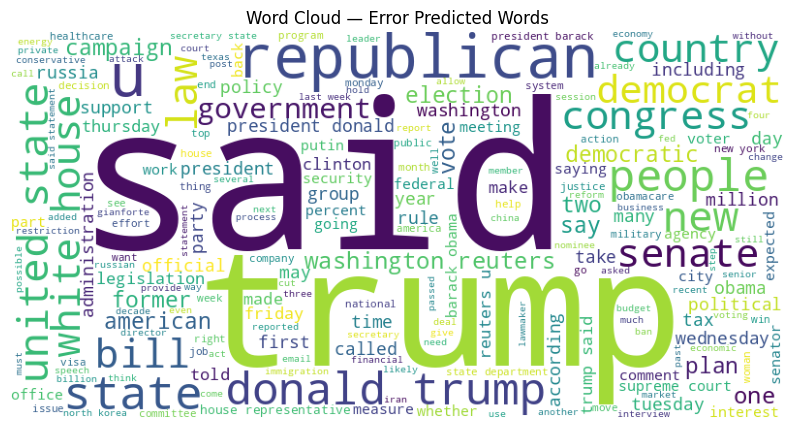

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# for Error Predicted News
error_words = ' '.join(error_df['clean_text'])
wc_error = WordCloud(width=800, height=400, background_color='white').generate(error_words)
plt.figure(figsize=(10,6))
plt.imshow(wc_error)
plt.axis('off')
plt.title('Word Cloud — Error Predicted Words')
plt.show()

# User Part

In [ ]:
# menu.py
import sys
# from google.colab import runtime

# from ml_model import load_model, predict_news, model_metrics, preprocess_text, vectorizer

def predict():
    model = load_model('model.pkl')
    # пример простой предсказательной процедуры:
    user_input = input("Enter text of news: ")
    user_input = preprocess_text(user_input)
    X_tfidf_new = vectorizer.transform([user_input])
    result = predict_news(model, X_tfidf_new)
    probas = model.predict_proba(X_tfidf_new)
    proba_fake = probas[0, 1]
    print(f"Probability this news is fake: {proba_fake:.2%}")
    if result == 1:
        result = 'fake'
    else:
        result = 'real'
    print(f"Prediction: {result}")
    input("Press enter to back menu")


def show_metrics():
    print("\nMain Metrics:")
    for k, v in model_metrics.items():
        print(f"{k}: {v:.3f}")
    input("\nPress enter to back menu")

def exit_menu():
    print("Exit...")
    sys.exit()
    # runtime.unassign()

def main_menu():
    while True:
        print("""
====================================
Main menu:
1 - Predict news (is fake)
2 - Show main metrics
3 - Exit
====================================
Your choice: """, end='')
        choice = input().strip()
        if choice == '1':
            predict()
        elif choice == '2':
            show_metrics()
        elif choice == '3':
            exit_menu()
        else:
            print("Wrong choice, try again")

# if __name__ == "__main__":
main_menu()



Main menu:
1 - Predict news (is fake)
2 - Show main metrics
3 - Exit
Your choice: 1
Enter text of news: Heavy rainfall floods the camps of displaced Palestinians in Gaza Gaza City  —  Displaced Palestinians in Gaza woke up Friday morning to inches of water flooding their tents, after heavy rainfall overnight left their shelters and belongings soaked with no way to dry them out.  Officials in Gaza have received “hundreds of pleas for help,” Mahmoud Basal, the spokesperson for Gaza Civil Defense, told journalists, “but the resources are nonexistent.”  “Entire shelter centers have seen water levels rise to more than 10 centimeters (3.94 inches). Mattresses are soaked, blankets are drenched and there are no options left — because every option has been destroyed by Israel,” he said.  Displaced Palestinians in Gaza City told CNN that the tents people were staying in were worn out, with some collapsing under the weight of the rain.  “We have been flooded by the rain, us and our little childr